In [1]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# Specific IC stuff
import IC.invisible_cities.core.system_of_units  as units


#Necessary to open configuration information
from IC.invisible_cities.io.mcinfo_io import load_mcconfiguration
from IC.invisible_cities.io.mcinfo_io import load_mcparticles_df
from IC.invisible_cities.io.mcinfo_io import load_mchits_df
from IC.invisible_cities.io.mcinfo_io import load_mcsensor_positions
from IC.invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from IC.invisible_cities.io.mcinfo_io import get_sensor_types
from IC.invisible_cities.io.mcinfo_io import get_sensor_binning
from IC.invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from IC.invisible_cities.core.core_functions import in_range

In [2]:
NN= -999999  # No Number, a trick to aovid nans in data structs

class NNN:

    def __getattr__(self, _):
        return NN

In [15]:
def sipm_pos(sipm_positions, pitch, verbose=False, eps=0.1, icount=100):
    """Takes a dataframe with the sipm_positions and:
    1. drops z position (not needed)
    2. for each sipm computes the xl, xr, yu, yd positions corresponding to:
       xl : sipm to the left along x axis of the sipm at position (x,y)
       xr : sipm to the right along x axis of the sipm at position (x,y)
       yu : sipm up along y axis of the sipm at position (x,y)
       yd : sipm down along y axis of the sipm at position (x,y)
       
    """
    
    def return_index(x,y):
        spx = sipm_positions[in_range(sipm_positions.x, x-eps, x+eps)]
        spxy = spx[in_range(spx.y, y-eps, y+eps)]
        if len(spxy.sensor_id.values) > 0:
            return spxy.sensor_id.values[0]
        else:
            return NN

    
    def compute_position(px, py, PMIN, PMAX, coord):
        if verbose: 
            print(f'compute position: px ={px}, py = {py}')
        
        xl, xr = px - pitch, px + pitch 
        if coord == 'x':
            ixl = return_index(xl,py)
            ixr = return_index(xr,py)
        else:
            ixl = return_index(py,xl)
            ixr = return_index(py,xr)

        if ixl   == NN:
            xl = NN
        elif ixr == NN:
            xr = NN

        return xl, xr

    xL = []
    xR = []
    yU = []
    yD = []
    
    X = sipm_positions.x.values
    Y = sipm_positions.y.values
    #function edited, column 'index' not included in fullsim
    new_positions = (sipm_positions.drop(columns=['z'])).copy()
    for i, (xpos, ypos) in enumerate(zip(X,Y)): 
        if verbose and i%icount == 0:
            print(i)
        
        xl, xr = compute_position(xpos, ypos, XMIN, XMAX, coord='x')
        yu, yd  = compute_position(ypos, xpos, YMIN, YMAX, coord='y')
        
        if verbose and i%icount == 0:
            print(f' sipm = {i}, x = {xpos}, y = {ypos}, xl = {xl}, yl = {yu}, xr = {xr}, yd = {yd}')
            
        
        xL.append(xl)
        xR.append(xr)
        yU.append(yu)
        yD.append(yd)
    
    new_positions['xl'] = xL
    new_positions['xr'] = xR
    new_positions['yu'] = yD  # yD is really yup
    new_positions['yd'] = yU
    
    return new_positions

In [4]:
def sipm_pos_test(sipm_map, pitch, verbose=False, eps=0.1, icount=100):
    """Tests that the difference between left-right (up-down) is 2 * pitch
       skipping SiPMs in the edges
    """
    XL = sipm_map.xl.values
    XR = sipm_map.xr.values
    YU = sipm_map.yu.values
    YD = sipm_map.yd.values
    P = np.array(len(XL) *[2 * pitch])
    DX = [xr - xl if xl != NN and xr != NN else 2 * pitch for xl,xr in zip(XL, XR) ]
    DY = [yu - yd if yu != NN and yd != NN else 2 * pitch for yu,yd in zip(YU, YD) ]
    t1 = np.allclose(DX, P, rtol=1e-03, atol=1e-03)
    t2 = np.allclose(DY, P, rtol=1e-03, atol=1e-03)
    return t1 and t2

In [5]:
def sipm_indx(sipm_map, eps=0.1):
    """Takes a dataframe with the sipm_map and adds de sipm indexes of xl, xr, yl, yr
    """
    def index_search(xv, yv, XL):
        spx  = sipm_map[in_range(sipm_map.x, xv - eps, xv + eps)] 
        spxy = spx[in_range(spx.y, yv - eps, yv + eps)]
        if len(spxy.sensor_id.values) == 1:
            XL.append(spxy.sensor_id.values[0])
        else:
            XL.append(NN)
    iXL=[]
    iXR=[]
    iYU=[]
    iYD=[]
    for i in sipm_map.index:
        sipm = sipm_map.loc[i]
        index_search(sipm.xl, sipm.y,  iXL)
        index_search(sipm.xr, sipm.y,  iXR)
        index_search(sipm.x,  sipm.yu, iYU)
        index_search(sipm.x,  sipm.yd, iYD)

    sipm_map['id_xl'] = iXL
    sipm_map['id_xr'] = iXR
    sipm_map['id_yu'] = iYU
    sipm_map['id_yd'] = iYD

In [6]:
def sipm_indx_test(sipm_map, eps=0.1):
    """Checks that the indexes match along one direction (X --- indexes always jump in units one one)
    """
    XL = sipm_map.id_xl.values
    XR = sipm_map.id_xr.values
    YU = sipm_map.id_yu.values
    YD = sipm_map.id_yd.values
    DX = [xr - xl if xl != NN and xr != NN else 2 for xl,xr in zip(XL, XR) ]
    t1 = np.allclose(DX, 2, rtol=1e-03, atol=1e-03)
    return t1

## Import DATA

In [26]:
filepath = '/Users/halmamol/NEXT/nexus/'
filename = 'NEW_NeutronGun_test.next.h5'
file = filepath+filename
#SiPM pitch hardcoded
sipm_pitch = 10 #mm

In [8]:
VERBOSITY = True

# Verbosing main config parameters
if VERBOSITY:
    mcConfig = load_mcconfiguration(file)

In [9]:
get_sensor_binning(file)

,bin_width
sns_name,
PmtR11410,100.0
SiPM,1000.0


In [27]:
sns_positions = load_mcsensor_positions(file)
#sns_positions

In [46]:
sns_response = load_mcsensor_response_df(file)
sns_response

charge     time
event_id sensor_id                 
2        18018           1  15000.0
         21033           1  15000.0
         16004           1  15000.0
         9023            1  15000.0
         28012           1  15000.0
...                    ...      ...
9        6013            1      0.0
10       18063           1   1000.0
         9032            1   1000.0
         10036           1   1000.0
         3026            1   1000.0

[283 rows x 2 columns]

In [ ]:
particles = pd.read_hdf(h5file_highE, 'MC/particles')

In [29]:
#all the SiPM are called with the same name, PMTs are named 'PmtR11410'
sipm_positions = sns_positions[sns_positions.sensor_name == 'SiPM']
#sipm_positions

,sensor_id,sensor_name,x,y,z
0,18018,SiPM,25.0,-55.0,-12.215
1,21033,SiPM,125.0,135.0,-12.215
2,16004,SiPM,5.0,125.0,-12.215
3,9023,SiPM,-55.0,235.0,-12.215
4,28012,SiPM,175.0,-75.0,-12.215
5,7052,SiPM,-95.0,-75.0,-12.215
18,1043,SiPM,-185.0,75.0,-12.215
19,12013,SiPM,-65.0,-25.0,-12.215
20,23003,SiPM,85.0,-5.0,-12.215
21,11056,SiPM,-5.0,5.0,-12.215


In [32]:
#to define the (x,y) limits, the min/max positions are retrieved
XMAX = sipm_positions.x.max()
XMIN = sipm_positions.x.min()
YMAX = sipm_positions.y.max()
YMIN = sipm_positions.y.min()
print(f'XMAX = {XMAX} XMIN = {XMIN} YMAX = {YMAX} YMIN = {YMIN}')

XMAX = 185.0 XMIN = -205.0 YMAX = 235.0 YMIN = -215.0


In [34]:
sipm_map = sipm_pos(sipm_positions, sipm_pitch, verbose=False, eps=0.1)

In [35]:
sipm_map

,sensor_id,sensor_name,x,y,xl,xr,yu,yd
0,18018,SiPM,25.0,-55.0,-999999.0,35.0,-45.0,-999999.0
1,21033,SiPM,125.0,135.0,-999999.0,135.0,145.0,-999999.0
2,16004,SiPM,5.0,125.0,-999999.0,15.0,135.0,-999999.0
3,9023,SiPM,-55.0,235.0,-999999.0,-45.0,245.0,-999999.0
4,28012,SiPM,175.0,-75.0,-999999.0,185.0,-65.0,-999999.0
5,7052,SiPM,-95.0,-75.0,-999999.0,-85.0,-65.0,-999999.0
18,1043,SiPM,-185.0,75.0,-999999.0,-175.0,85.0,-999999.0
19,12013,SiPM,-65.0,-25.0,-999999.0,-55.0,-15.0,-999999.0
20,23003,SiPM,85.0,-5.0,75.0,-999999.0,-999999.0,-15.0
21,11056,SiPM,-5.0,5.0,-999999.0,5.0,15.0,-999999.0


In [36]:
sipm_pos_test(sipm_map, sipm_pitch, verbose=False, eps=0.1, icount=100)

True

In [37]:
sipm_indx(sipm_map)
sipm_map

,sensor_id,sensor_name,x,y,xl,xr,yu,yd,id_xl,id_xr,id_yu,id_yd
0,18018,SiPM,25.0,-55.0,-999999.0,35.0,-45.0,-999999.0,-999999,-999999,-999999,-999999
1,21033,SiPM,125.0,135.0,-999999.0,135.0,145.0,-999999.0,-999999,-999999,-999999,-999999
2,16004,SiPM,5.0,125.0,-999999.0,15.0,135.0,-999999.0,-999999,-999999,-999999,-999999
3,9023,SiPM,-55.0,235.0,-999999.0,-45.0,245.0,-999999.0,-999999,-999999,-999999,-999999
4,28012,SiPM,175.0,-75.0,-999999.0,185.0,-65.0,-999999.0,-999999,-999999,-999999,-999999
5,7052,SiPM,-95.0,-75.0,-999999.0,-85.0,-65.0,-999999.0,-999999,-999999,-999999,-999999
18,1043,SiPM,-185.0,75.0,-999999.0,-175.0,85.0,-999999.0,-999999,-999999,-999999,-999999
19,12013,SiPM,-65.0,-25.0,-999999.0,-55.0,-15.0,-999999.0,-999999,-999999,-999999,-999999
20,23003,SiPM,85.0,-5.0,75.0,-999999.0,-999999.0,-15.0,18063,-999999,-999999,23002
21,11056,SiPM,-5.0,5.0,-999999.0,5.0,15.0,-999999.0,-999999,-999999,-999999,-999999


In [24]:
sipm_indx_test(sipm_map)

True

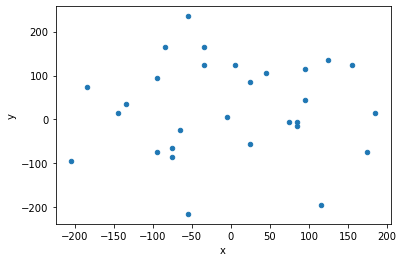

In [38]:
sipm_map.plot(kind='scatter', x='x', y='y')

In [39]:
sipm_map.to_csv('sipm_map.csv')